# Erweiterte Visualisierung
Gelegentlich ermöglicht es die grafische Darstellung eines Graphen, Informationen und Muster zu erkennen. In diesem Abschnitt soll Ihnen gezeigt werden, wie ein Layout Algorithmus angewendet und das Ergebnis mit Plotly dargestellt wird.

## Inhaltsverzeichnis
- [Vorbereitung](#Vorbereitung)
- [Layout Algorithmen](#Layout-Algorithmen)
- [Plotly](#Plotly)
- [Information durch Einfärben](#Information-durch-Einfärben)
- [Abschließende Bemerkung](#Abschließende-Bemerkung)
- [Hinweise zum Datensatz](#Hinweise-zum-Datensatz)

## Vorbereitung
Importieren Sie zunächst NetworkX und den Graphen. Die Daten enthalten als Knoten die wichtigsten Schauspieler aller Erzeugnisse. Eine Kante wird zwischen zwei Knoten angelegt, wenn die Schauspieler an mindestens zwei gemeinsamen Werken mitwirkten.

In [ ]:
import networkx as nx
G = nx.read_edgelist('cast_graph.csv', data=False, delimiter=',')

str(G)

## Layout Algorithmen
Layout Algorithmen erstellen eine Art Landkarte aus einem gegebenen Graphen. Sie nutzen verschiedene Modelle und Simulationen, um Knoten nach einem nützlichen Muster anzuordnen. [ForceAtlas](https://gephi.wordpress.com/2011/06/06/forceatlas2-the-new-version-of-our-home-brew-layout/) ist ein bekannter Algorithmus, der nach mechanischen Prinzipien arbeitet, sodass sich Knoten gegenseitig abstoßen, durch Kanten aber zusammengezogen werden. Demnach entfernen sich Gruppen mit wenigen Verbindungen voneinander, während dicht vernetzte Teilgraphen Ansammlungen bilden.

Eine [Implementierung in Python](https://github.com/bhargavchippada/forceatlas2) steht zur Verfügung. Die folgende Zelle orientiert sich weitestgehend an einem Beispiel auf der Projektseite und berechnet das entsprechende Layout für den importierten Graphen.

In [ ]:
from fa2_modified import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.9,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=3.0,
    strongGravityMode=False,
    gravity=1,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=3000)

Nachdem die gewünschte Anzahl an Iterationen durchgeführt wurde, werden die Positionen in einem Dictionary gespeichert. Als Schlüssel dient die Bezeichnung des Knotens. Die Werte enthalten Tupel der Form `(x, y)`.

In [ ]:
positions['Ewan McGregor']

## Plotly
Für viele beliebte Arten der grafischen Darstellung besitzt Plotly fertige Funktionen im Paket `plotly.express`. Zur Zeichnung eines Graphen mit benutzerdefinierten Koordinaten steht jedoch keine solche zur Verfügung. Im Folgenden wird deshalb das Paket `plotly.graph_objects` genutzt, das deutlich mehr Kontrolle über die einzelnen Darstellungen erlaubt.

In [ ]:
import plotly.graph_objects as go

Die Darstellung wird aufgeteilt in Kanten und Knoten. Beiden werden verschiedene Eigenschaften zugewiesen, bevor sie gemeinsam gezeichnet werden.

Sollten Sie diesen Code nicht vollständig verstehen, genügt es, ihn an geeigneter Stelle zu kopieren und anzupassen. Sofern Sie mehr über die Darstellung von Graphen mit Plotly erfahren wollen, ist womöglich [die entsprechende Website](https://plotly.com/python/network-graphs/) hilfreich.

In [ ]:
def draw_graph(pos, additional_data=None, column=None):
    # Vorbereitung der Kanten
    edge_trace = go.Scatter(
        x=sum(((pos[source][0], pos[target][0], None) for source, target in G.edges), ()),
        y=sum(((pos[source][1], pos[target][1], None) for source, target in G.edges), ()),
        mode='lines',
        line=dict(
            width=0.5,
            color='#888'
        ),
        hoverinfo='none'
    )

    # Vorbereitung der Knoten
    node_trace = go.Scatter(
        x=[n[0] for _, n in pos.items()],
        y=[n[1] for _, n in pos.items()],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='sunsetdark',
            reversescale=True,
            color=[],
            size=8,
            colorbar=dict(
                thickness=15,
                title=column,
                xanchor='left',
                titleside='right'
            ),
            line_width=2
        )
    )

    # Hinzufügen zusätzlicher Knoten-Informationen
    if additional_data is not None:
        data = {n: v for _, (n, v) in additional_data[['name', column]].iterrows()}
        color = [data[str(n)] for n in G.nodes()]

        node_trace.text = list(zip(G.nodes(), color))
        node_trace.marker.color = color
    else:
        node_trace.text = list(G.nodes())

    # Darstellung beider Bestandteile
    return go.Figure(data=[edge_trace, node_trace],
                     layout=go.Layout(
                         titlefont_size=16,
                         showlegend=False,
                         hovermode='closest',
                         margin=dict(
                             b=0,
                             l=0,
                             r=0,
                             t=0),
                         xaxis=dict(
                             showgrid=False,
                             zeroline=False,
                             showticklabels=False
                         ),
                         yaxis=dict(
                             showgrid=False,
                             zeroline=False,
                             showticklabels=False
                         )
                     ))


draw_graph(positions)

Es ist bereits zu erkennen, dass es eine große Menge an Schauspielern gibt, die sich in einem Cluster sammeln und untereinander eine relativ große Anzahl an Verbindungen pflegen. Zudem sind weitere kleinere Cluster zu erkennen, während sich im äußeren Bereich einzelne Schauspieler und kleine Gruppen sammeln, die untereinander keine Kanten besitzen.

Dank Plotly können Sie in diesem Graphen nun nach Belieben zoomen und scrollen. Im Detail lassen sich zum Beispiel ein Star-Wars- und ein Marvel-Cluster finden. Verbunden werden diese durch Schauspieler, die in beiden Franchises mitspielten, wie beispielsweise Natalie Portman oder Samuel L. Jackson.

## Information durch Einfärben
Zuletzt sollen weitere Muster gesucht werden, indem eine dritte Dimension als farbliche Markierung der einzelnen Knoten in die Darstellung einfließt.

Laden Sie zunächst Pandas und die Datei `cast_type.csv`, in der sich weitere Details zu jedem Schauspieler befinden:
- `known_for` beinhaltet:
    - `red`, falls der Schauspieler in einem Marvel Film mitwirkte,
    - `blau`, falls der Schauspieler in einem Star Wars Film mitwirkte
    - und `NaN`, falls nichts von beidem zutrifft.

  Diese Spalte ist händisch hinzugefügt worden und daher nicht ansatzweise vollständig.
- `ratio` ist eine Zahl im Intervall $[0, 1]$ und spiegelt das Verhältnis aus Filmen und Serien wider. Ein Wert von $1$ bedeutet, dass nur Filme produziert wurden, während ein Wert von $0$ bedeutet, dass ausschließlich an Serien mitgearbeitet wurde.
- `vote_average` ist die durchschnittliche Nutzerwertung aller Werke.
- `release_year_average` ist das durchschnittliche Veröffentlichungsjahr.

In [ ]:
import pandas as pd
additional_data = pd.read_csv('cast_type.csv')

additional_data

Mit Hilfe dieser Daten können Knoten eingefärbt werden. Wird dabei die Spalte `known_for` gewählt, bestätigt sich die Vorahnung zweier sich bildender Häufungen. Eventuell entdecken Sie bei der Erkundung der weiteren Features weitere Muster, die Ihre Vorahnungen bestätigen oder Ihnen sogar komplett neu sind.

In [ ]:
from ipywidgets import interact

@interact(column=['known_for', 'release_year_min', 'ratio', 'vote_average'])
def _(column):
    return draw_graph(
        positions,
        additional_data,
        column
    )

## Abschließende Bemerkung
Sie haben nun gesehen, wie ein Graph anhand eines komplexen Algorithmus visuell dargestellt werden kann. Berücksichtigen Sie aber auch die Erkenntnis, dass aus einer unscheinbaren Verknüpfung deutlich mehr an Einblicken zu gewinnen ist, als man zunächst annehmen würde. So reicht bereits ein einziges Feauture - nämlich die Zusammenarbeit zweier Schauspieler - aus, um im großen Rahmen ganze Franchises visuell zu entdecken.

Stellen Sie sich nun aber vor, die herausgefundene Zuordnung wäre gar nicht für die Öffentlichkeit bestimmt. Aus vermeintlich harmlosen Daten, zum Beispiel wie häufig und zu welcher Zeit Sie Messenger-Nachrichten an eine andere Person senden, lassen sich plötzlich Rückschlüsse auf private Beziehungen oder Zusammenarbeit ziehen - grafisch an jeden vermittelbar und ohne auch nur eine einzige Nachricht zu entschlüsseln.

Einen Vortrag von David Kriesel, der diese Gefahren neben der Mächtigkeit der grafischen Darstellung von Graphen adressiert, finden Sie unter [media.ccc.de](https://media.ccc.de/v/33c3-7912-spiegelmining_reverse_engineering_von_spiegel-online).

## Hinweise zum Datensatz
Ein Teil der Ihnen zur Verfügung gestellten Daten wurden mit Hilfe der TMDb API erzeugt. Die Verwendung wird weder von TMDb unterstützt noch zertifiziert.

[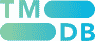](https://developers.themoviedb.org/3)